In [ ]:
import datetime as dt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import date

from influxdb_client import InfluxDBClient, Point, Dialect
from influxdb_client.client.write_api import SYNCHRONOUS
from matplotlib import pyplot as plt

# Insert token
MY_TOKEN = "dsu8fZNL4p_n3kbucBgIifNSkF8BTptODBfhctSfNZAxbJ5DTx6tQXFZHVfAwuSjAABfSfZnxO99Mv9pg-oqTg=="

client = InfluxDBClient(url="http://eagle.sintef.no:8086", token=MY_TOKEN, org="SINTEF")

write_api = client.write_api(write_options=SYNCHRONOUS)
query_api = client.query_api()


In [2]:
import warnings
from influxdb_client.client.warnings import MissingPivotFunction

warnings.simplefilter("ignore", MissingPivotFunction)

DURATION = '365d'
RESOLUTION = '60m'


"""
Query: using Pandas DataFrame
"""
t_room = query_api.query_data_frame('from(bucket: "zeb")'
f'|> range(start: -{DURATION})'
'|> filter(fn: (r) => r["_measurement"] == "569.")'
'|> filter(fn: (r) => r["Point"] == "Room temperature")'
f'|> aggregateWindow(every: {RESOLUTION}, fn: mean, createEmpty: false)') # Use fn: mean for the mean of the RESOLUTION or fn:last for the latest sample
# To simplify, we take the mean of the component level RT601, RT602 etc. to create one room level sensors 
# only applies to first and second floor (cafeteria & twin rooms has multiple room sensors)
t_floor = pd.concat(t_room).pivot_table(index="_time", columns=["Floor"], values="_value", aggfunc="mean").replace(0, None)
t_room = pd.concat(t_room).pivot_table(index="_time", columns=["Floor","Room"], values="_value", aggfunc="mean").replace(0, None)

"""
Query: using Pandas DataFrame
"""
sp_room = query_api.query_data_frame('from(bucket: "zeb")'
f'|> range(start: -{DURATION})'
'|> filter(fn: (r) => r["_measurement"] == "569.")'
'|> filter(fn: (r) => r["Point"] == "Present heating setpoint")'
f'|> aggregateWindow(every: {RESOLUTION}, fn: mean, createEmpty: false)')
sp_floor = sp_room.pivot_table(index="_time", columns=["Floor"], values="_value", aggfunc="mean").replace(0, None)
sp_room = sp_room.pivot_table(index="_time", columns=["Floor","Room"], values="_value", aggfunc="mean").replace(0, None)


In [3]:
# Read the room list
roomlist = pd.read_excel('ZEBLAB_Room_info.xlsx')
roomlist = pd.read_csv('ZEBLAB_Room_info.csv', sep=';')

# Match roomcode with how Room key is written in Influx
roomlist.index = roomlist['Roomcode'].apply(str).apply(lambda x: x[0] + '.' + x[1:])


In [12]:
# Create a df for the mean values
t_room_mean = pd.DataFrame(index= t_room.index)

for floor in range(1,5,1):
    
    # Create a two lists to 
    #weighthed_rows, simplemean_rows

    # All temperatures
    s = t_room[str(floor)]

    # An empty list that stores the values
    values = []
    for room in s.keys():
        floor_area = roomlist[roomlist.index==room].Floor_area
        values.append(floor_area.values[0])

    # Calculate the sum of the list
    total_sum = sum(values)

    # Divide each element by the sum
    normalized_values = [value / total_sum for value in values]
    print('Normalizing floor', str(floor), 'with weighting factors: ', normalized_values)

    # In theory we can simply multiply, buit in case of NA values the sum becomes wrong.
    #t_room_mean['Floor_' + str(floor)] = (s * normalized_values).sum(axis=1)

    # Instead, we iterate over rows the rows, and only if there are None values in the row,
    #  we fallback to a simple arithmetic mean
    for index, row in s.iterrows():
        if row.isnull().any():
            # If any value in the row is None (NaN), calculate the mean of the row
            mean_value = np.nanmean(row.values)
            t_room_mean.loc[index, 'Floor_' + str(floor)] = mean_value
            t_room_mean.loc[index, 'Floortypeofmean_' + str(floor)] = 'simple_arithmetic_mean'
        else:
            # If there are no None values, calculate the weighted sum
            weighted_sum = sum(val * weight for val, weight in zip(row.values, normalized_values))
            t_room_mean.loc[index, 'Floor_' + str(floor)] = weighted_sum
            t_room_mean.loc[index, 'Floortypeofmean_' + str(floor)] = 'area_weighted_mean'


Normalizing floor 1 with weighting factors:  [0.20509147464494742, 0.2032087750173945, 0.5916997503376581]


C:\Users\kristians\AppData\Local\Temp\ipykernel_22820\1171410786.py:33: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(row.values)


Normalizing floor 2 with weighting factors:  [0.10238113122511831, 0.14433260722601968, 0.17156163148801923, 0.08360249380304965, 0.24840381581912419, 0.24971832043866896]


C:\Users\kristians\AppData\Local\Temp\ipykernel_22820\1171410786.py:33: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(row.values)


Normalizing floor 3 with weighting factors:  [0.10625528968223437, 0.1838116488420405, 0.1820804801107948, 0.04308686619989228, 0.04204816496114488, 0.10425482803723937, 0.07324767253981687, 0.18550434715703623, 0.07971070246980072]


C:\Users\kristians\AppData\Local\Temp\ipykernel_22820\1171410786.py:33: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(row.values)


Normalizing floor 4 with weighting factors:  [0.6068760288717234, 0.3931239711282766]


C:\Users\kristians\AppData\Local\Temp\ipykernel_22820\1171410786.py:33: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(row.values)


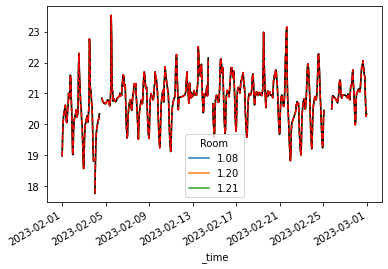

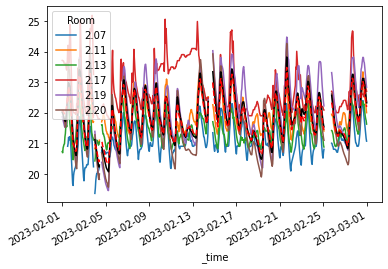

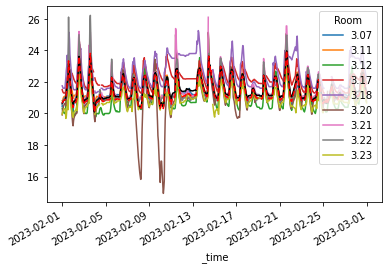

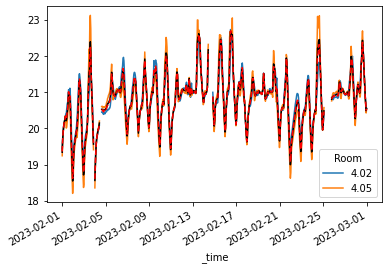

In [15]:
for i in range(1,5):
    idx = str(i)

    # Ploot room level temperatures
    t_room[idx]['2023-02':'2023-02'].plot()

    # Plot floor temperature (arithmetic mean)
    t_floor[idx]['2023-02'].plot(color='black')
    # Plot are weighted floor temperature (when available)
    t_room_mean['Floor_' + idx]['2023-02':'2023-02'].plot(color='red', style='--')
    plt.show()



<Axes: xlabel='_time'>

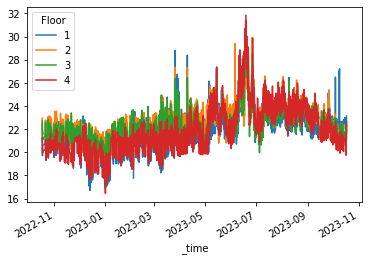

In [16]:
# Plot floor temperatures
t_floor.plot()